In [11]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ModelFinal').getOrCreate()

In [12]:
traintest = spark.read.csv("traintest2.csv", header=True, inferSchema=True)
traintest.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ACTIVITYESTIMATE: string (nullable = true)
 |-- WEEK: integer (nullable = true)
 |-- POP: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- HealthCare_All: double (nullable = true)
 |-- HealthCare_Over65: double (nullable = true)
 |-- INCOME: integer (nullable = true)
 |-- TypeA_subH3: integer (nullable = true)
 |-- TypeA_subH1N1: integer (nullable = true)
 |-- TypeA: integer (nullable = true)
 |-- TypeA_subH3N2: integer (nullable = true)
 |-- TypeA_subU: integer (nullable = true)
 |-- TypeA_subH1: integer (nullable = true)
 |-- PrevWeek: string (nullable = true)
 |-- NSporadic: integer (nullable = true)
 |-- NLocalAct: integer (nullable = true)
 |-- NNoAct: integer (nullable = true)
 |-- NRegional: integer (nullable = true)
 |-- NWidespread: double (nullable = true)
 |-- Density: double (nullable = true)



In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)
from pyspark.ml.linalg import Vectors

In [14]:
State_indexer = StringIndexer(inputCol='STATENAME',outputCol='StateIndex')
State_encoder = OneHotEncoder(inputCol='StateIndex',outputCol='StateVec')

Activity_indexer = StringIndexer(inputCol='ACTIVITYESTIMATE',outputCol='ActivityIndex')
Activity_encoder = OneHotEncoder(inputCol='ActivityIndex',outputCol='ActivityVec')

Season_indexer = StringIndexer(inputCol='SEASON',outputCol='SeasonIndex')
Season_encoder = OneHotEncoder(inputCol='SeasonIndex',outputCol='SeasonVec')

PrevWeek_indexer = StringIndexer(inputCol='PrevWeek',outputCol='PrevWeekIndex')
PrevWeek_encoder = OneHotEncoder(inputCol='PrevWeekIndex',outputCol='PrevWeekVec')

In [15]:
assembler = VectorAssembler(
  inputCols=['WEEK',
             'POP',
             'AREA',
             'HealthCare_All',
             'HealthCare_Over65',
             'INCOME',
             'TypeA_subH3',
             'TypeA_subH1N1',
             'TypeA',
             'TypeA_subH3N2',
             'TypeA_subU',
             'TypeA_subH1',
             'PrevWeekVec',
             'NSporadic',
             'NLocalAct',
             'NNoAct',
             'NRegional',
             'NWidespread',
            'Density'],
    outputCol="features")

# Final Model

In [18]:
dt = DecisionTreeClassifier(labelCol="ActivityIndex", featuresCol="features", maxDepth=5, maxBins=40,minInstancesPerNode=11)
pipeline = Pipeline(stages=[Activity_indexer,PrevWeek_indexer,
                               Activity_encoder,PrevWeek_encoder,
                               assembler,dt])

(train, test) = traintest.randomSplit([0.9, 0.1])

fit_model = pipeline.fit(train)

prediction_dt = fit_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="ActivityIndex", predictionCol="prediction", metricName="accuracy")
print(evaluator.evaluate(prediction_dt))

0.793040293040293


# K -fold

In [16]:
kfold = []
for k in range (0,10):
    dt = DecisionTreeClassifier(labelCol="ActivityIndex", featuresCol="features", maxDepth=5, maxBins=40,minInstancesPerNode=11)
    pipeline = Pipeline(stages=[Activity_indexer,PrevWeek_indexer,
                               Activity_encoder,PrevWeek_encoder,
                               assembler,dt])

    (train, test) = traintest.randomSplit([0.9, 0.1])

    fit_model = pipeline.fit(train)

    prediction_dt = fit_model.transform(test)

    evaluator = MulticlassClassificationEvaluator(labelCol="ActivityIndex", predictionCol="prediction", metricName="accuracy")
    kfold.append(evaluator.evaluate(prediction_dt))


{'boxes': [<matplotlib.lines.Line2D at 0x7fc861306390>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc86130c940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc861309748>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fc86130c6d8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc8613064e0>,
  <matplotlib.lines.Line2D at 0x7fc8613063c8>]}

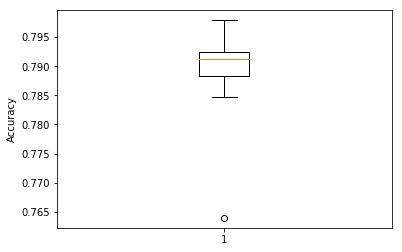

In [17]:
import matplotlib.pyplot as plt 

fig1, ax1 = plt.subplots()
plt.ylabel('Accuracy')
ax1.boxplot(kfold)